(array([117., 135., 108., 111.,  93.,  70.,  59.,  57.,  49.,  32.,  23.,
         28.,  28.,  21.,   8.,  11.,  12.,   6.,   4.,  10.,   3.,   2.,
          1.,   3.,   0.,   0.,   0.,   1.,   1.,   1.,   0.,   1.,   0.,
          0.,   1.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([1.64218337e-05, 7.79238652e-04, 1.54205547e-03, 2.30487229e-03,
        3.06768911e-03, 3.83050592e-03, 4.59332274e-03, 5.35613956e-03,
        6.11895638e-03, 6.88177320e-03, 7.64459002e-03, 8.40740683e-03,
        9.17022365e-03, 9.93304047e-03, 1.06958573e-02, 1.14586741e-02,
        1.22214909e-02, 1.29843077e-02, 1.37471246e-02, 1.45099414e-02,
        1.52727582e-02, 1.60355750e-02, 1.67983918e-02, 1.75612087e-02,
        1.83240255e-02, 1.90868423e-02, 1.98496591e-02, 2.06124759e-02,
        2.13752927e-02, 2.21381096e-02, 2.29009264e-02, 2.36637432e-02,
        2.44265600e-02, 2.51893768e-02, 2.59521937e-02, 2.67150105e-02,
        2.

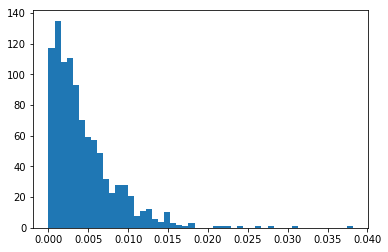

In [237]:
import numpy as np
import math
import matplotlib.pyplot as plt
plt.tight_layout()
import time

class site:
    def __init__(self, position, properties):
        self.index = position
        for name,value in properties.items():
            setattr(self, name, value)
        

class AndersonHopp:
    def __init__(self, inL, inT, inW):
        self.W = inW
        self.t = inT
        self.L = int(inL)
        self.system = []
        self.spectrum = []
        self.eigen = []
        self.x = []
        for i in range(self.L):
            self.x.append(np.exp(i * 1j * math.pi * 2 / self.L))
        self.x = np.diag(self.x)
        self.H = np.zeros((self.L,self.L)) + self.t*(np.diag(np.ones(self.L-1),1) + np.diag(np.ones(self.L-1),-1))
        for i in range(self.L):
            self.system.append(site(i, {'t':inT, 'U':np.random.uniform(-self.W/2,self.W/2)}))
            self.H[i,i] = self.system[i].U
        self.solve()
        
        
    def solve(self):
        temp = np.linalg.eigh(self.H)
        self.spectrum = temp[0]
        self.eigen = temp[1]
#        for wave in self.eigen:
 #           out, sub = plt.subplots(1)
  #          sub.plot(wave)



    def reparam(self, Wnew):
        self.W = Wnew
        self.rescramble()
    
    def rescramble(self, Wsingle = None):
        if Wsingle == None:
            Wsingle = self.W
        for i in range(self.L):
            self.system[i].U = np.random.uniform(-Wsingle/2,Wsingle/2)
            self.H[i,i] = self.system[i].U
        self.solve()
        
    def levelSpace(self):
        out = []
        for i in range(self.L-1):
            out.append(self.spectrum[i+1]-self.spectrum[i])
        return out
    
    def CoM(self, index=-.5):
        if not(index+.5):
            out = []
            for i in range(self.L):
                out.append(self.L/(2*math.pi) * np.imag(np.log(np.vdot(self.eigen[i], np.dot(self.x, self.eigen[i])))))
            return out
        else:
            if index == int(index) and abs(index + .5)<self.L:
                return (self.L/(2*math.pi) * np.imag(np.log(np.vdot(self.eigen[index], np.dot(self.x, self.eigen[index])))))
            else:
                print("CoM passed bad index")
                return
    
    def IPR(self, index=-.5):
        if not(index+.5):
            out = []
            for i in range(self.L):
                out.append(sum(np.power(np.absolute(self.eigen[i]),4)))
            return out
        else:
            if index == int(index) and abs(index + .5)<self.L:
                return sum(np.power(np.absolute(self.eigen[index]),4))
            else:
                print("IPR passed bad index")
                return
    
    def locLength(self, index=-.5):
        if not(index+.5):
            loclens = []
            centers = np.rint(self.CoM())
            for i in range(self.L):
                wf = self.eigen[i]
                loclens.append(0)
                for j in range(-int(self.L/2),int(self.L/2)):
                    loclens[-1] += np.sqrt((j*wf[int(centers[i])+j])**2)
            return loclens
        else:
            if index == int(index) and abs(index + .5)<self.L:
                wf = self.eigen[index]
                loclen = 0
                center = np.rint(self.CoM(index))
                for j in range(-int(self.L/2),int(self.L/2)):
                    loclen += np.sqrt((j*wf[int(center[index])+j])**2)
                return loclen
            else:
                print("locLength passed bad index")
                return
    
    def sweepRange(self,Wstart,Wstop,Wsteps,inFunct):
        Wstep = (Wstop - Wstart)/Wsteps
        outlist = []
        for w in np.arange(Wstart,Wstop,Wstep):
            self.reparam(w+Wstep)
            outlist.append(np.mean(inFunct()))
        return outlist
    
#    def WFout(self):
 #       vector = []
  #      for site in self.system:
   #         vector.append(site.wf)
    #    return vector
    
    def E(self):
        E=0
        for i in range(int(-self.L/2),int(self.L/2)):
            E+=self.system[i].wf*self.Hi(i)
        return E
    
    def Hi(self, i):
        return (t*(self.system[i-1].wf + self.system[i+1].wf) + self.system[i].U * self.system[i].wf)
    
#    def timeEvolve(self, dt):
#        wfnext = [0]*L
 #       for i in range(int(-L/2),int(L/2)):
  #          wfnext[i] = exp(j*dt*Hi(i))


L = 1000
t = 1
W = .75

ander = AndersonHopp(L, t, W)


#print(gaussian.eigen[4])
#print(gaussian.CoM(),gaussian.spectrum)
out, sub = plt.subplots(1)
sub.hist(ander.levelSpace(),50)
#sub.plot(ander.sweepRange(0,10,200,ander.locLength))

